In [1]:
import numpy as np, matplotlib.pyplot as plt, torch
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.problems.functional import FunctionalProblem
from tqdm import tqdm

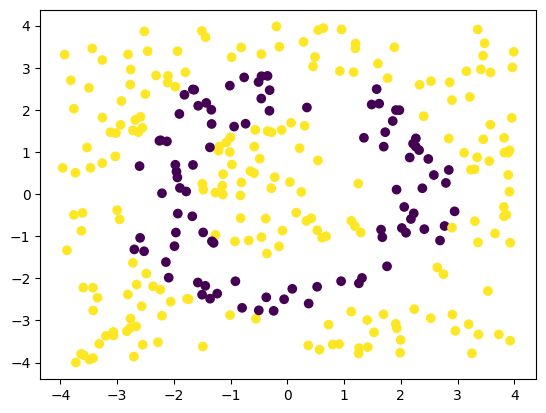

In [2]:
def decison_bound (x,y):
    return x**2 + y**2 <=3 or x**2 + y**2 >=9
def generate_data (n=100, bound=decison_bound):
    X = np.random.uniform(-4,4,(n,2))
    Y = np.array([1 if bound(x[0],x[1]) else 0 for x in X])
    return X,Y

X,Y = generate_data(300)
plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()

In [3]:
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
dataset = TensorDataset(torch.tensor(X).float(), torch.tensor(Y).long())
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
class SimpleNN (nn.Module):
    def __init__ (self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,2)

        )
    def forward (self,x):
        return self.net(x)
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
bar=tqdm(range(100), desc="Training", ncols=80, unit="epoch", colour="green")
for epoch in bar:

    for xb, yb in dataloader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    bar.set_postfix(loss=loss.item())


# Visualize decision boundary
from utils import plot_proba



Training: 100%|████████████████| 100/100 [00:01<00:00, 57.60epoch/s, loss=0.101]


(<Figure size 520x460 with 2 Axes>,
 <Axes: title={'center': 'Class 1 probability surface'}, xlabel='x0', ylabel='x1'>)

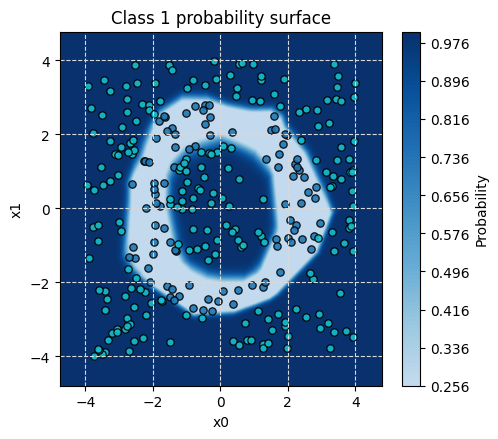

In [ ]:

plot_proba(model, X, Y)

In [ ]:

def make_cf_problem(model, x_star, Y_prime, X_obs, weights):

    model.eval()

    # ------- 准备 numpy 版本的数据（pymoo 用 numpy） -------
    x_star_t = x_star.detach().cpu()
    X_obs_t = X_obs.detach().cpu()
    Y_prime_t = Y_prime.detach().cpu()
    w_t = weights.detach().cpu()

    x_star_np = x_star_t.numpy()            # shape: (p,)
    X_obs_np = X_obs_t.numpy()              # shape: (k, p)
    w_np = w_t.numpy()                      # shape: (k,)
    p = x_star_np.shape[0]                  # 特征维数 p

    # 搜索空间：简单用观测数据的 min/max，当作上下界
    xl = X_obs_np.min(axis=0)
    xu = X_obs_np.max(axis=0)

    feature_range = X_obs_np.max(axis=0) - X_obs_np.min(axis=0)
    feature_range[feature_range == 0] = 1.0    # 避免除以 0

    def delta_G_vec(x, y):
        # normalized |x - y| in [0, 1]
        return np.minimum(np.abs(x - y) / feature_range, 1.0)

    # ------- 4 个目标函数（elementwise，输入 1 个 x） -------

    # 1) Validity：o1(f(x), Y') = 0 if f(x) in Y', else inf_{y' in Y'} |f(x) - y'|
    # 这里把 f(x) 当作预测类别（argmax），Y' 当作目标类别集合，
    # 并在类别空间上用 0/1 距离。
    def o1_validity(x):
        x_t = torch.from_numpy(x.astype(np.float32)).unsqueeze(0)  # shape: (1, p)
        with torch.no_grad():
            logits = model(x_t)            # shape: (1, num_classes)
            y_hat_class = int(logits.argmax(dim=1).item())  # 标量类别

        # Y_prime_t 可能是一个标量或 1D 张量，把它统一成类别列表
        target_labels = Y_prime_t.view(-1).long().tolist()

        # formal definition:
        # if f(x) ∈ Y' -> 0
        # else inf_{y'∈Y'} |f(x) - y'|, 用 0/1 距离 => 1
        if y_hat_class in target_labels:
            return 0.0
        else:
            return 1.0

    # 2) Similarity：和 x* 的平均归一化差异（越小越相似）
    def o2_similarity(x):
        return float(delta_G_vec(x, x_star_np).mean())
    
    EPS = 0.02    # or something like 1e-8

    def o3_sparsity(x):
        # ||x - x*||_0 = number of coordinates that changed
        diff=0
        for i in range(len(x_star_np)):
            if abs(x[i] - x_star_np[i]) > EPS:
                diff += 1
        return float(diff)

    def o4_plausibility(x):
        diffs = (X_obs_np - x) / feature_range            # (k, p)
        per_sample = np.sqrt((diffs ** 2).mean(axis=1))   # RMS distance per sample
        w_np_norm = w_np / w_np.sum()
        return float((per_sample * w_np_norm).sum())

    objs = [o1_validity, o2_similarity, o3_sparsity, o4_plausibility]
    problem = FunctionalProblem(
    n_var=p,
    objs=objs,
    xl=xl,
    xu=xu,
    elementwise=True  # 每次传入一个个体 x
)

    return problem

In [6]:
for x, y in dataloader:
    x_star = torch.tensor([-3.0, -2.0])        # original feature vector, tensor shape (p,)
    y_star = model(x_star.unsqueeze(0)).argmax(dim=1)          # original label, tensor scalar
    Y_prime = 1 - y_star   # target label = opposite class, still a tensor
    break

X_obs = dataset.tensors[0]                       # (k, p)
weights = torch.ones(len(X_obs)) / len(X_obs)    # normalized weights

# model:      PyTorch 模型
# x_star:     shape (p,)
# Y_prime:    shape (n_y,)  例如 tensor([1]) 或几种目标输出
# X_obs:      shape (k, p)
# weights:    shape (k,)   且 weights.sum() == 1

problem = make_cf_problem(model, x_star, Y_prime, X_obs, weights)
print(f'problem: \n{problem}\nx_star: {x_star} dtype={x_star.dtype}\ny_star: {y_star} dtype={y_star.dtype}\nY_prime: {Y_prime} dtype={Y_prime.dtype}\n')


problem: 
# name: FunctionalProblem
# n_var: 2
# n_obj: 4
# n_ieq_constr: 0
# n_eq_constr: 0

x_star: tensor([-3., -2.]) dtype=torch.float32
y_star: tensor([1]) dtype=torch.int64
Y_prime: tensor([0]) dtype=torch.int64



In [7]:

# 3. 选择算法（NSGA-II）
algorithm = NSGA2(pop_size=200)

# 4. 终止条件
termination = get_termination("n_gen", 150)

# 5. 运行优化
res = minimize(
    problem,
    algorithm,
    termination,
    seed=1,
    verbose=True
)

F_mmo = res.F   # shape (n_points, 4)  — 4 个目标的值
X_mmo = res.X   # 对应的 x（counterfactual 候选）

abs(x[0] - x_star_np[0]) = 2.3560705403460127
abs(x[1] - x_star_np[1]) = 3.7489080858120047
abs(x[0] - x_star_np[0]) = 0.9572342592088381
abs(x[1] - x_star_np[1]) = 0.4143990794134207
abs(x[0] - x_star_np[0]) = 0.20817506397813812
abs(x[1] - x_star_np[1]) = 1.2608170566217445
abs(x[0] - x_star_np[0]) = 0.5221291524472855
abs(x[1] - x_star_np[1]) = 0.7592494533984562
abs(x[0] - x_star_np[0]) = 2.1951009916626165
abs(x[1] - x_star_np[1]) = 2.3009392891745133
abs(x[0] - x_star_np[0]) = 2.3733362037747665
abs(x[1] - x_star_np[1]) = 3.4688598129829193
abs(x[0] - x_star_np[0]) = 0.6667073843402327
abs(x[1] - x_star_np[1]) = 5.0076931560804745
abs(x[0] - x_star_np[0]) = 0.7404848430742281
abs(x[1] - x_star_np[1]) = 3.351176571282804
abs(x[0] - x_star_np[0]) = 2.3583180282596405
abs(x[1] - x_star_np[1]) = 2.459475875897792
abs(x[0] - x_star_np[0]) = 0.15755886400430352
abs(x[1] - x_star_np[1]) = 0.41709901787096326
abs(x[0] - x_star_np[0]) = 5.405642488115625
abs(x[1] - x_star_np[1]) = 5.72681

In [8]:
valided_F_mmo=np.array([f for f in F_mmo if f[0]==0])
valided_X_mmo=np.array([X_mmo[i] for i in range(len(F_mmo)) if F_mmo[i][0]==0])
not_valided_F_mmo=np.array([f for f in F_mmo if f[0]!=0])
not_valided_X_mmo=np.array([X_mmo[i] for i in range(len(F_mmo)) if F_mmo[i][0]!=0])
not_patero_front_X=np.array([X_obs[i] for i in range(len(X_obs)) if i not in res.opt.get("idx")])  # observed instances not in pareto front

In [9]:
abs(np.array([-1.97828342, -1.99436237])-x_star.numpy()), problem.evaluate(np.array([-1.97828342, -1.99436237]))

abs(x[0] - x_star_np[0]) = 1.02171658
abs(x[1] - x_star_np[1]) = 0.00563763000000006


(array([1.02171658, 0.00563763]),
 array([0.        , 0.0646338 , 1.        , 0.33787467]))

In [10]:
[x  for x in valided_X_mmo if abs(abs(x[1])-2) <=0.02 ]

[array([-2.13322695, -2.00146494]),
 array([-1.68524041, -1.99506916]),
 array([-1.62927105, -2.00221568]),
 array([-1.86889718, -1.98325605]),
 array([-1.87577147, -2.00221568]),
 array([-2.11384214, -1.9952399 ]),
 array([-1.29713413, -1.99151501]),
 array([-2.01046444, -2.0000322 ]),
 array([-1.60117792, -2.00096773]),
 array([-1.79219719, -1.99506916]),
 array([-1.57379979, -1.98050515]),
 array([-1.04254774, -1.99506916]),
 array([-1.10901984, -1.99121967]),
 array([-2.03672641, -1.99216651]),
 array([-1.76560707, -1.99996075]),
 array([-0.82935531, -2.01374497]),
 array([-0.94552606, -1.98318729]),
 array([-0.9777381, -1.9993275]),
 array([-2.03672641, -2.00275457])]

In [11]:
why=[valided_X_mmo[i] for i in range(len(valided_X_mmo)) if valided_F_mmo[i][2]==0 ]
why

[]

In [12]:
problem.evaluate(why[0]),why[0]

IndexError: list index out of range

In [ ]:
1.978283425-3

-1.021716575

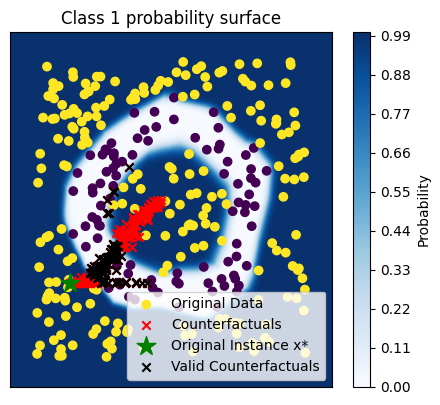

In [ ]:

# visualize the conterfactuals candidates in original data space
fig,ax=plot_proba(model, X)

ax.scatter(X[:,0],X[:,1],c=Y, label='Original Data')
ax.scatter(X_mmo[:,0], X_mmo[:,1], marker='x', c='red', label='Counterfactuals')
ax.scatter(x_star[0], x_star[1], marker='*', c='green', s=200, label='Original Instance x*')
# color black for valid counterfactuals
ax.scatter(valided_X_mmo[:,0], valided_X_mmo[:,1], marker='x', c='black', label='Valid Counterfactuals')
ax.legend()

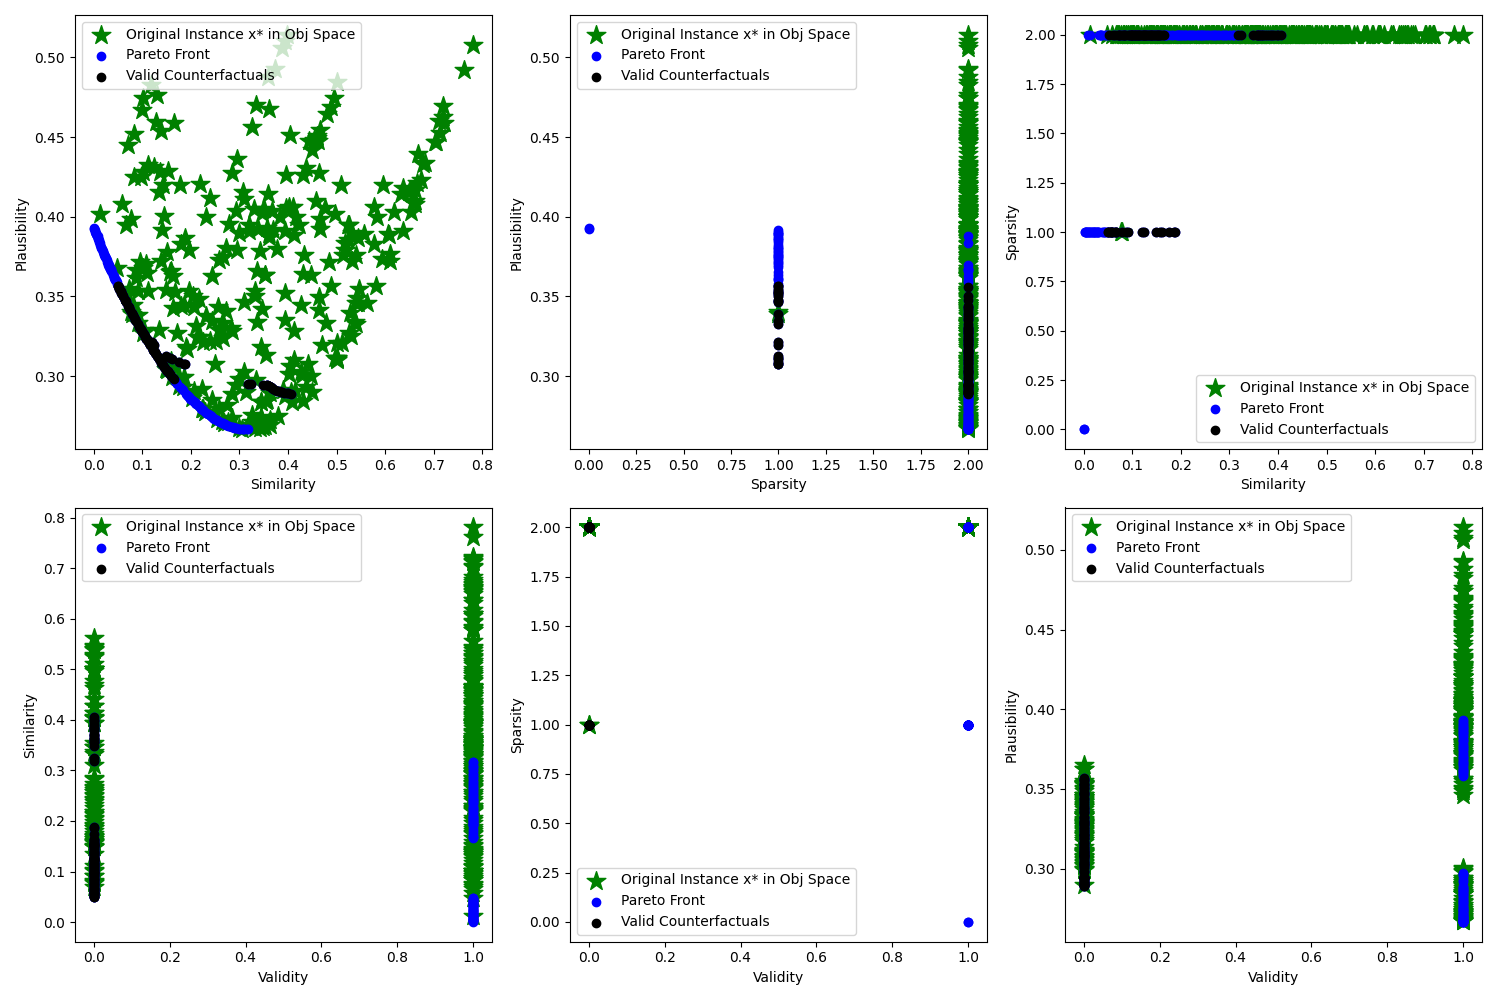

In [ ]:
# visualize the Pareto front in objective space
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Create pairs of objective indices to plot
obj_pairs = [(1, 3), (2, 3), (1, 2), (0, 1), (0, 2), (0, 3)]
obj_labels = ['Validity', 'Similarity', 'Sparsity', 'Plausibility']

for i, (obj_x, obj_y) in enumerate(obj_pairs):
    row = i // 3
    col = i % 3
    ax[row, col].scatter(problem.evaluate(X)[:, obj_x],
                         problem.evaluate(X)[:, obj_y],
                         marker='*', c='green', s=200, label='Original Instance x* in Obj Space')
    ax[row, col].scatter(F_mmo[:, obj_x], F_mmo[:, obj_y], c='blue', label='Pareto Front')
    ax[row, col].scatter(valided_F_mmo[:, obj_x], valided_F_mmo[:, obj_y], c='black', label='Valid Counterfactuals')
    ax[row, col].set_xlabel(obj_labels[obj_x])
    ax[row, col].set_ylabel(obj_labels[obj_y])
    ax[row, col].legend()

plt.tight_layout()
plt.show()

abs(x[0] - x_star_np[0]) = 5.522388674666005
abs(x[1] - x_star_np[1]) = 5.919673440295846
abs(x[0] - x_star_np[0]) = 0.4208807485574555
abs(x[1] - x_star_np[1]) = 5.082736530138022
abs(x[0] - x_star_np[0]) = 1.9955800913962758
abs(x[1] - x_star_np[1]) = 2.9289032985600922
abs(x[0] - x_star_np[0]) = 4.553107387480199
abs(x[1] - x_star_np[1]) = 0.08271944480604088
abs(x[0] - x_star_np[0]) = 3.337465917283877
abs(x[1] - x_star_np[1]) = 5.95755245432253
abs(x[0] - x_star_np[0]) = 1.7144046444201404
abs(x[1] - x_star_np[1]) = 0.25098100156857583
abs(x[0] - x_star_np[0]) = 3.3469354124796187
abs(x[1] - x_star_np[1]) = 1.1552985735413595
abs(x[0] - x_star_np[0]) = 1.9241915710011224
abs(x[1] - x_star_np[1]) = 4.95620343917984
abs(x[0] - x_star_np[0]) = 0.593813545563278
abs(x[1] - x_star_np[1]) = 3.4429051649492814
abs(x[0] - x_star_np[0]) = 4.914047160296752
abs(x[1] - x_star_np[1]) = 1.3668055941527468
abs(x[0] - x_star_np[0]) = 0.699917906554786
abs(x[1] - x_star_np[1]) = 0.449689543243826

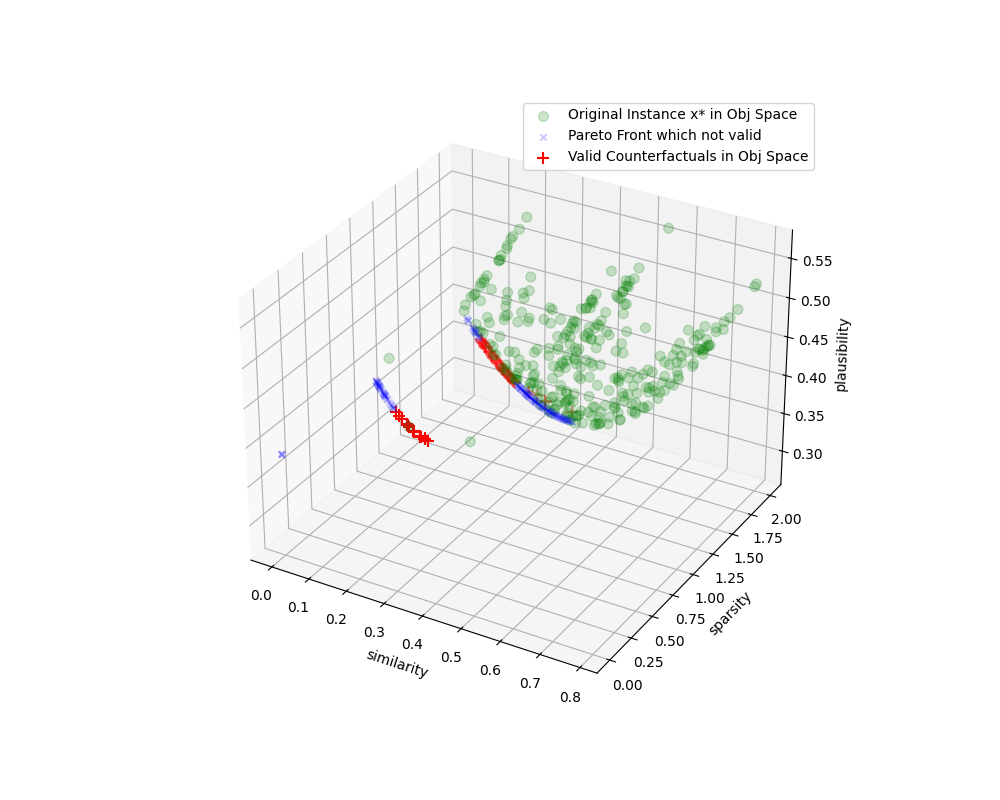

In [ ]:

%matplotlib widget
# visualize the Pareto front in 3D objective space
plt.figure(figsize=(10, 8))
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')

ax.scatter(problem.evaluate(X)[:,1],
            problem.evaluate(X)[:,2],
            problem.evaluate(X)[:,3],
            marker='.', c='green', s=200, label='Original Instance x* in Obj Space',alpha=0.2)
ax.scatter(not_valided_F_mmo[:,1], not_valided_F_mmo[:,2], not_valided_F_mmo[:,3], c='blue', label='Pareto Front which not valid', marker='x', s=20, alpha=0.2)
# color black for valid counterfactuals
ax.scatter(valided_F_mmo[:,1], valided_F_mmo[:,2], valided_F_mmo[:,3], c='red', label='Valid Counterfactuals in Obj Space', marker='+', s=80)
ax.set_xlabel('similarity')
ax.set_ylabel('sparsity')
ax.set_zlabel('plausibility')



plt.legend()
plt.show()

In [ ]:
poi=np.array([[0,0]])
problem.evaluate(poi), model(torch.tensor(poi).float().unsqueeze(0)).argmax(dim=1), Y_prime

(array([[1.        , 0.37679312, 2.        , 0.26656676]]),
 tensor([[0, 0]]),
 tensor([0]))